# **Building a Rat Detector!**
**Cohort**: MBD 23/24 - Computer Vision,
**Name:** Ignacio Alonso López-Linares


<img src="https://lumiere-a.akamaihd.net/v1/images/pp_ratatouille_herobanner_mobile_19736_4c2e46ac.jpeg?region=0,0,640,480" alt="Remy" width="600"/>


This notebook will walk you through creating a rat detector. It consists on annotating sample images with Grouding DINO and torchvision and then creating a model YOLO v10 to identify them! How cool is that!

# **Step 1: Annotate Images Using GroundingDINO**

1. Set Up Environment:
o Ensure your environment is set up with the necessary libraries and
dependencies. Refer to the provided notebooks for guidance. It is
recommended to work using colab.

2. Automatic Annotation:
o Use GroundingDINO to automatically annotate the images. This involves:

  *   Loading the image set.
  *   Running the GroundingDINO model to generate annotations.
  *   Saving the annotated images in a format suitable for YOLOv10
    training.

## 1.1 Set-Up the Environment!

### *1.1.1 Downloading GroundingDINO and packages:*

Making our Home Directory

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow #dataclasses-json onemetric


/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 443 (delta 158), reused 139 (delta 130), pack-reused 231
Receiving objects: 100% (443/443), 12.86 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (229/229), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.1 MB/s e

In [3]:
import torch
import roboflow
import pandas as pd

# Setting up PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
import shutil

from typing import List
import cv2
import supervision
import supervision as sv

In [5]:
# confirm that configuration file exist
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [4]:
# download weights file
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [6]:
# confirm that weights file exist

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [7]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
roboflow: 1.1.33 ; supervision: 0.4.0


### *1.1.2 Downloading the Data:*

In [7]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content
/content/data


We are about to download the rat training pictures from the shared repository. This will take a while. Be prepared to wait, go for a coffee or a walk in the meantime ⏰

In [9]:

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
mypydrive = GoogleDrive(gauth)

# Create destination directory
destination_dir = "/content/data"
os.makedirs(destination_dir, exist_ok=True)

# Folder ID from shared URL
folder_id = "1mEU4rK-sZPDUCU6x1Ij_zA78MCWLmwSG"

# List and download all files in the folder quietly
file_list = mypydrive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
for file in file_list:
    file.GetContentFile(os.path.join(destination_dir, file['title']))


After the downloaded data is stored in this folder, we will count the number of files to check that every image is in place.

In [10]:
destination_dir = "/content/data"
files = os.listdir(destination_dir)


# Count files
print(f"\nTotal number of files: {len(files)}")


Total number of files: 444


In [11]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model


model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### *1.1.3 Copying it to My Drive to not download the images again.*

In [13]:
# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive destination folder
google_drive_destination = "/content/drive/My Drive/Computer_Vision/Individual_Assignment/data"  # Replace 'your_folder' with your target folder in Google Drive
os.makedirs(google_drive_destination, exist_ok=True)

# Move files from Colab VM to Google Drive
for file in file_list:
    file_path = os.path.join(destination_dir, file['title'])
    shutil.copy(file_path, google_drive_destination)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Annotating images with Grouding Dino

NOTE: The provided dataset contains objects or images that are not rats but contain the representation of a rat: tattos, drawings and plushes of rats. We will ALSO annotate them as RATs. This was asked to the professor.

### *1.2.1 Initial Exploration*



Time to annotate the data! We will use the Enhanced Classes Inference Mode. We will predict with captions by attaching the class rat to the string. This could be further enhanced with a text prompt although it much more prone to errors.

In [14]:
SOURCE_IMAGE_PATH = f"{HOME}/data/rat_8.jpg" #"/content/drive/My Drive/Computer_Vision/Individual_Assignment/data/rat_8.jpg"
CLASSES = ['rat']
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.20


In [15]:

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


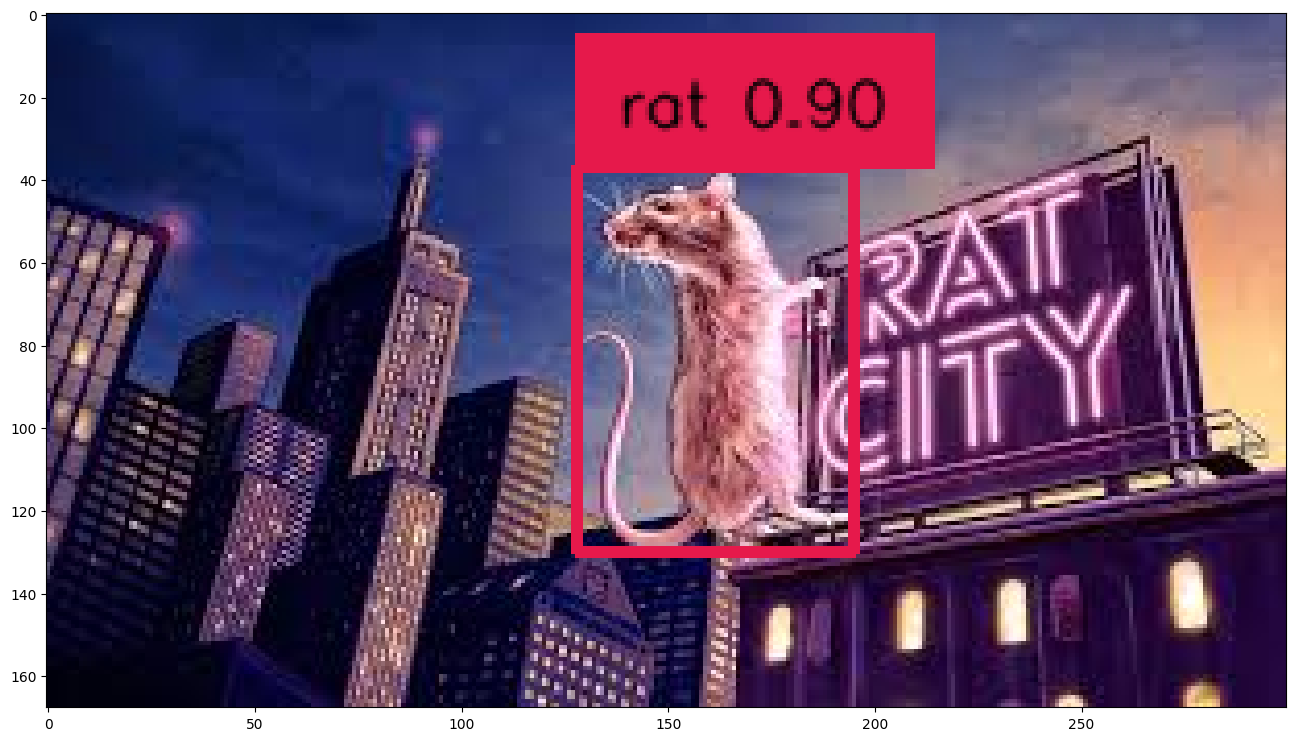

In [16]:
image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))




*   In a first attempt to create annotations, the model **suffers at identifying rats when they are together**, but excels at detecting them when alone in the picture or clearly separated from one another.

    Example: Rat_100.jpg

*  **Colour is also causing trouble**. When the background is similar to the colour of the fur, the model classifies it correctly, but it also makes the mistake of annotating a random square with the same colour.

    Example: Rat_2.jpg

I have checked many images and at this point, it is fairly good at labelling rats. We have two options: we can tune labels in Roboflow manually for those images that do not work well. We could also augment the dataset, but I think we have a good starting point and it is not needed nor desired by the assignment.

In this annotation loop, **we will apply iou** to solve for some mistakes when there are overlapping rats

NOTE: For duplicatin/overlapping rat boxes, we will use .with_nvm to just annotate 1 box.






### *1.2.2 Loop for Automatic Annotations using CLASSES*

In [17]:
import os
from roboflow import Roboflow

PROJECT_NAME = "rates"
PROJECT_DESCRIPTION = "annotations on rat images"
SOURCE_DIRECTORY_PATH = os.path.join(HOME, "data")
CLASSES = ['rat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

NOTE: There are two methods for identifying the desired objects.

*   model.predict_with_classes(): The model will only look for the class that you instantiated, in this case 'rat'

*   model.predict_with_caption(): The model will look at the caption, which is usually a TEXT_PROMPT. This gives us more flexibiliy but it is prone to erros.

We will use .predict_with_classes() since GroudingDINO has already been trained for this task.

In [18]:
# Initialize Roboflow with your API key
rf = Roboflow(api_key="assDfRv2tyOCR2ncPiLI")

# Get the workspace
workspace = rf.workspace()

# Create a new project
new_project = workspace.create_project(
    project_name="Rat-Detector",
    project_license="MIT",
    project_type="object-detection",
    annotation="rat"
)

print(f"Project created: {new_project}")

loading Roboflow workspace...
loading Roboflow project...
Project created: {
  "name": "Rat-Detector",
  "type": "object-detection",
  "workspace": "rats-phs43"
}


In [19]:
def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)


def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

PASCAL VOC XML formatting to upload the images and annotations to roboflow

In [20]:
from os import listdir


for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
        )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    detections = detections.with_nms() #fixing duplicate boxes

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


This will annotate 440 out of 444 images. These have been dropped due to the filters we applied.

### *1.2.3 Loop for Automatic Annotations using TEXT PROMPTS*

Even if we decided to annotate with the class, I will also give you the example classifying with TEXT PROMPTS using NLP



```

from os import listdir
TEXT_PROMPT = 'A rat is a long-tailed blablabla'

for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = model.predict_with_caption(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD  
        caption=TEXT_PROMPT  
        )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    detections = detections.with_nms() #fixing duplicate boxes

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)


```




At this point, we see Grouding DINO has annotated correctly most of the pictures. We will solve the cases where it does not annotate well, such as when it confuses the background  with the rat due to being of similar color or when it does not

### **At this point there is an encoding problem with the notebook so, please reset the notebook and run Step 2 independently.**

# **Step 2: Build and Train YOLOv10 Model**
1. Transfer Learning:
o Leverage pre-trained weights and apply transfer learning to the YOLOv10
model.
2. Training Process:

  * Split your annotated dataset into training and validation sets.(recommended 70%, 30% split)
  * Configure the YOLOv10 model training parameters.
  * Train the model using the annotated dataset.
  * Monitor the training process and evaluate the model's performance on the validation set.




3. Evaluation: (optional)
o Test the trained model on example images you scrape from the web to
evaluate its performance in detecting rats.

## 2.1 Transfer Learning with YOLOv10

First, we will download the YOLOv10 model family. Each letter corresponds to a model and it serves different purposes. YOLOv10n stands for "nano" while YOLOv10x stands for "extra-large". By now, you probably now the difference: for the fastest inference but also more prone to errors, we will use a smaller model - YOLOv10n while for slower inference but much more accurate results, we will use YOLOv10x

In [6]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We will also download YOLOv10 weights and model versions

In [7]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 1.1G
-rw-r--r-- 1 root root 662M Mar 21  2023 groundingdino_swint_ogc.pth
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


When creating the project, we pushed everything in the training set to label every photo in the same bucket. We will make the splitting within Roboflow so that we do not have to split it ourselves after downloading it.

Let's go!

## 2.2 Training Process

We will directly apply the split within the Roboflow platform

### *2.2.1 Splitting the Dataset and Downloading the annotated dataset from Roboflow*

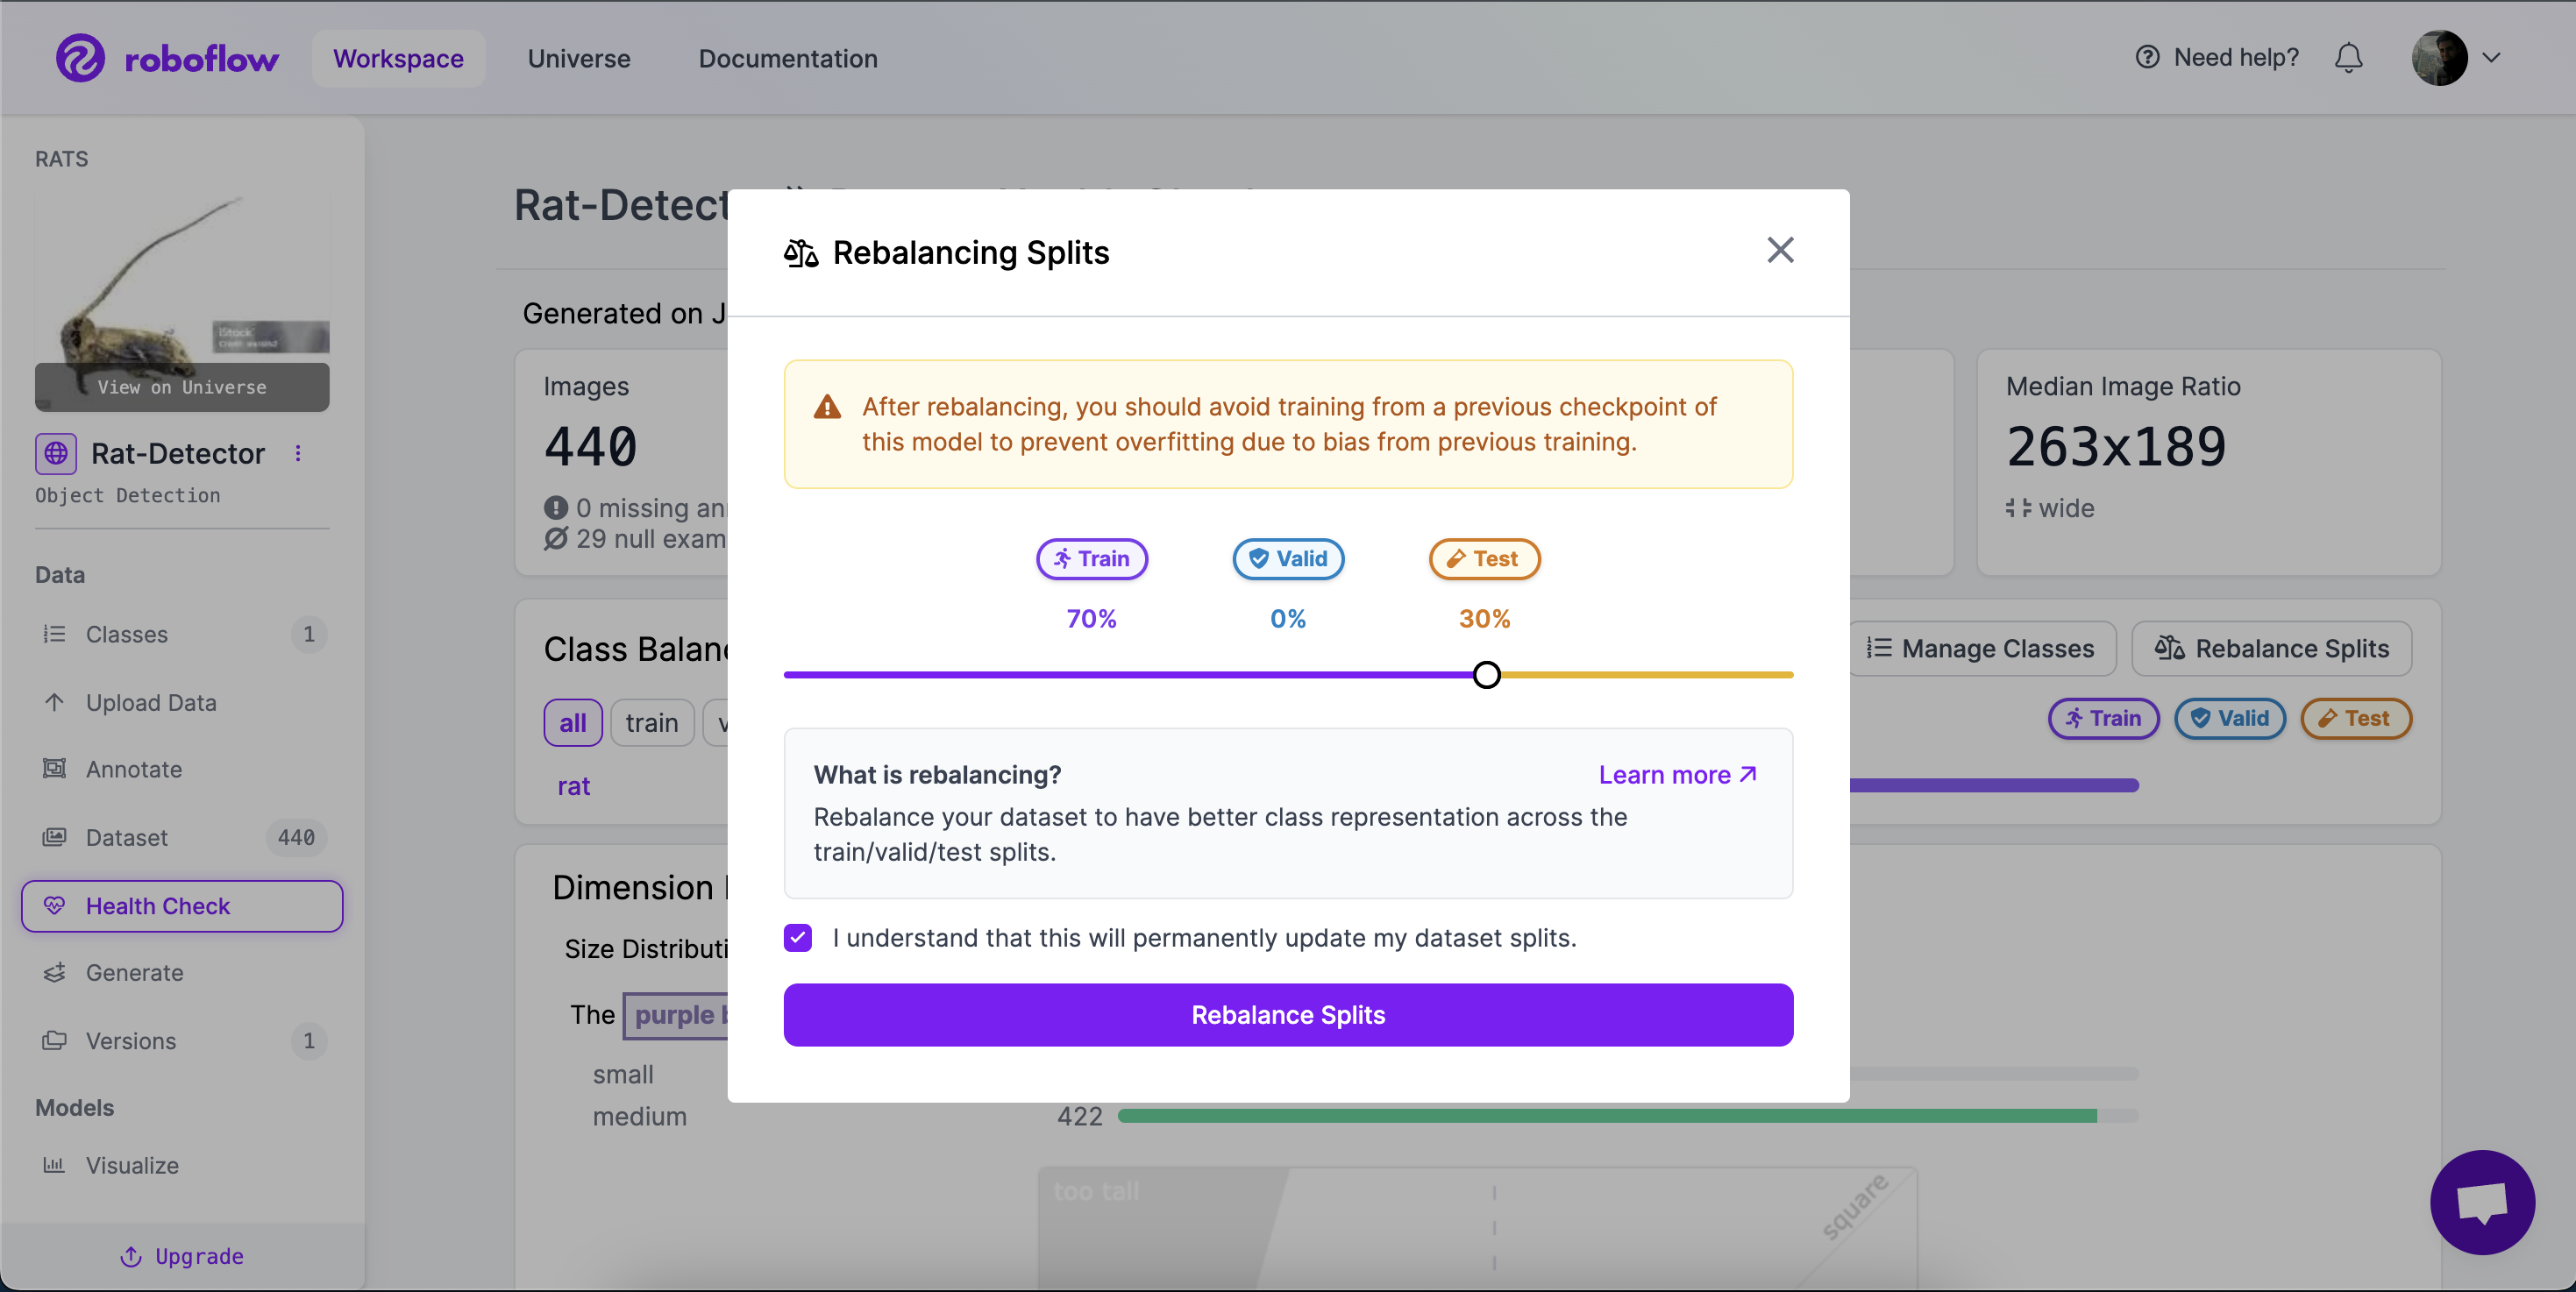

Let's import the model now... we will go with the extra-large .pt model

In [8]:
from ultralytics import YOLOv10
from IPython.display import Image

In [9]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

/content/datasets


And we will download our Roboflow project

In [10]:
from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY_HERE") #Your Roboflow API key
project = rf.workspace("rats-phs43").project("rat-detector-w6dmq")
version = project.version(3) #Version 3 train/val split
dataset = version.download("yolov8") #To train a YOLOv10, a YOLOv8 is suitable.

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Rat-Detector-3 in yolov8:: 100%|██████████| 889/889 [00:00<00:00, 9641.33it/s]


Now, we will set the path to the training and validation sets in the .yaml config file

In [11]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

### *2.2.2 Tune the YOLOv10 model training parameters and Training the YOLOv10 Model*


Initially, we tried with Optuna, but it is too complex to implement within Colab. We will use optimizer = AdamW the !yolo command line, so that it has some entropy and can do trials based on that to optimize the model.

We do not have time nor the compute units to parameter tune the model, but the idea is to try and fine-tune the script. Each one of this hyperparameters, for isntance hsv_v makes augmentations on the vertical plane while hsv_h does them in the horizontal plane, and this can make your model more robust :D!

In [ ]:

#!yolo task=detect mode=train epochs=100 batch=16 imgsz=640  weight_decay=0.0005, conf=0.35, optimizer="AdamW" \
#hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 degrees=5.0 translate=0.1 scale=0.5 shear=0.0 perspective=0.0 flipud=0.0 fliplr=0.5 mixup=0.0 \
#plots=True model={HOME}/weights/yolov10n.pt data={dataset.location}/data.yaml #lr0=0.001 momentum=0.9


We will use Stochastic Gradient Descent as it seems it is the best Optimizer for this task. We could also freeze the layers, but this did not make any substantial effect.

In [12]:
%cd {HOME}

!yolo task=detect mode=train epochs=150 optimizer="SGD" \
plots=True val=True augment=True \
model={HOME}/weights/yolov10s.pt data={dataset.location}/data.yaml #lr0=0.001 momentum=0.9 #AdamW


/content
New https://pypi.org/project/ultralytics/8.2.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10s.pt, data=/content/datasets/Rat-Detector-3/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=

### *2.2.3 Monitoring Training Process*

/content


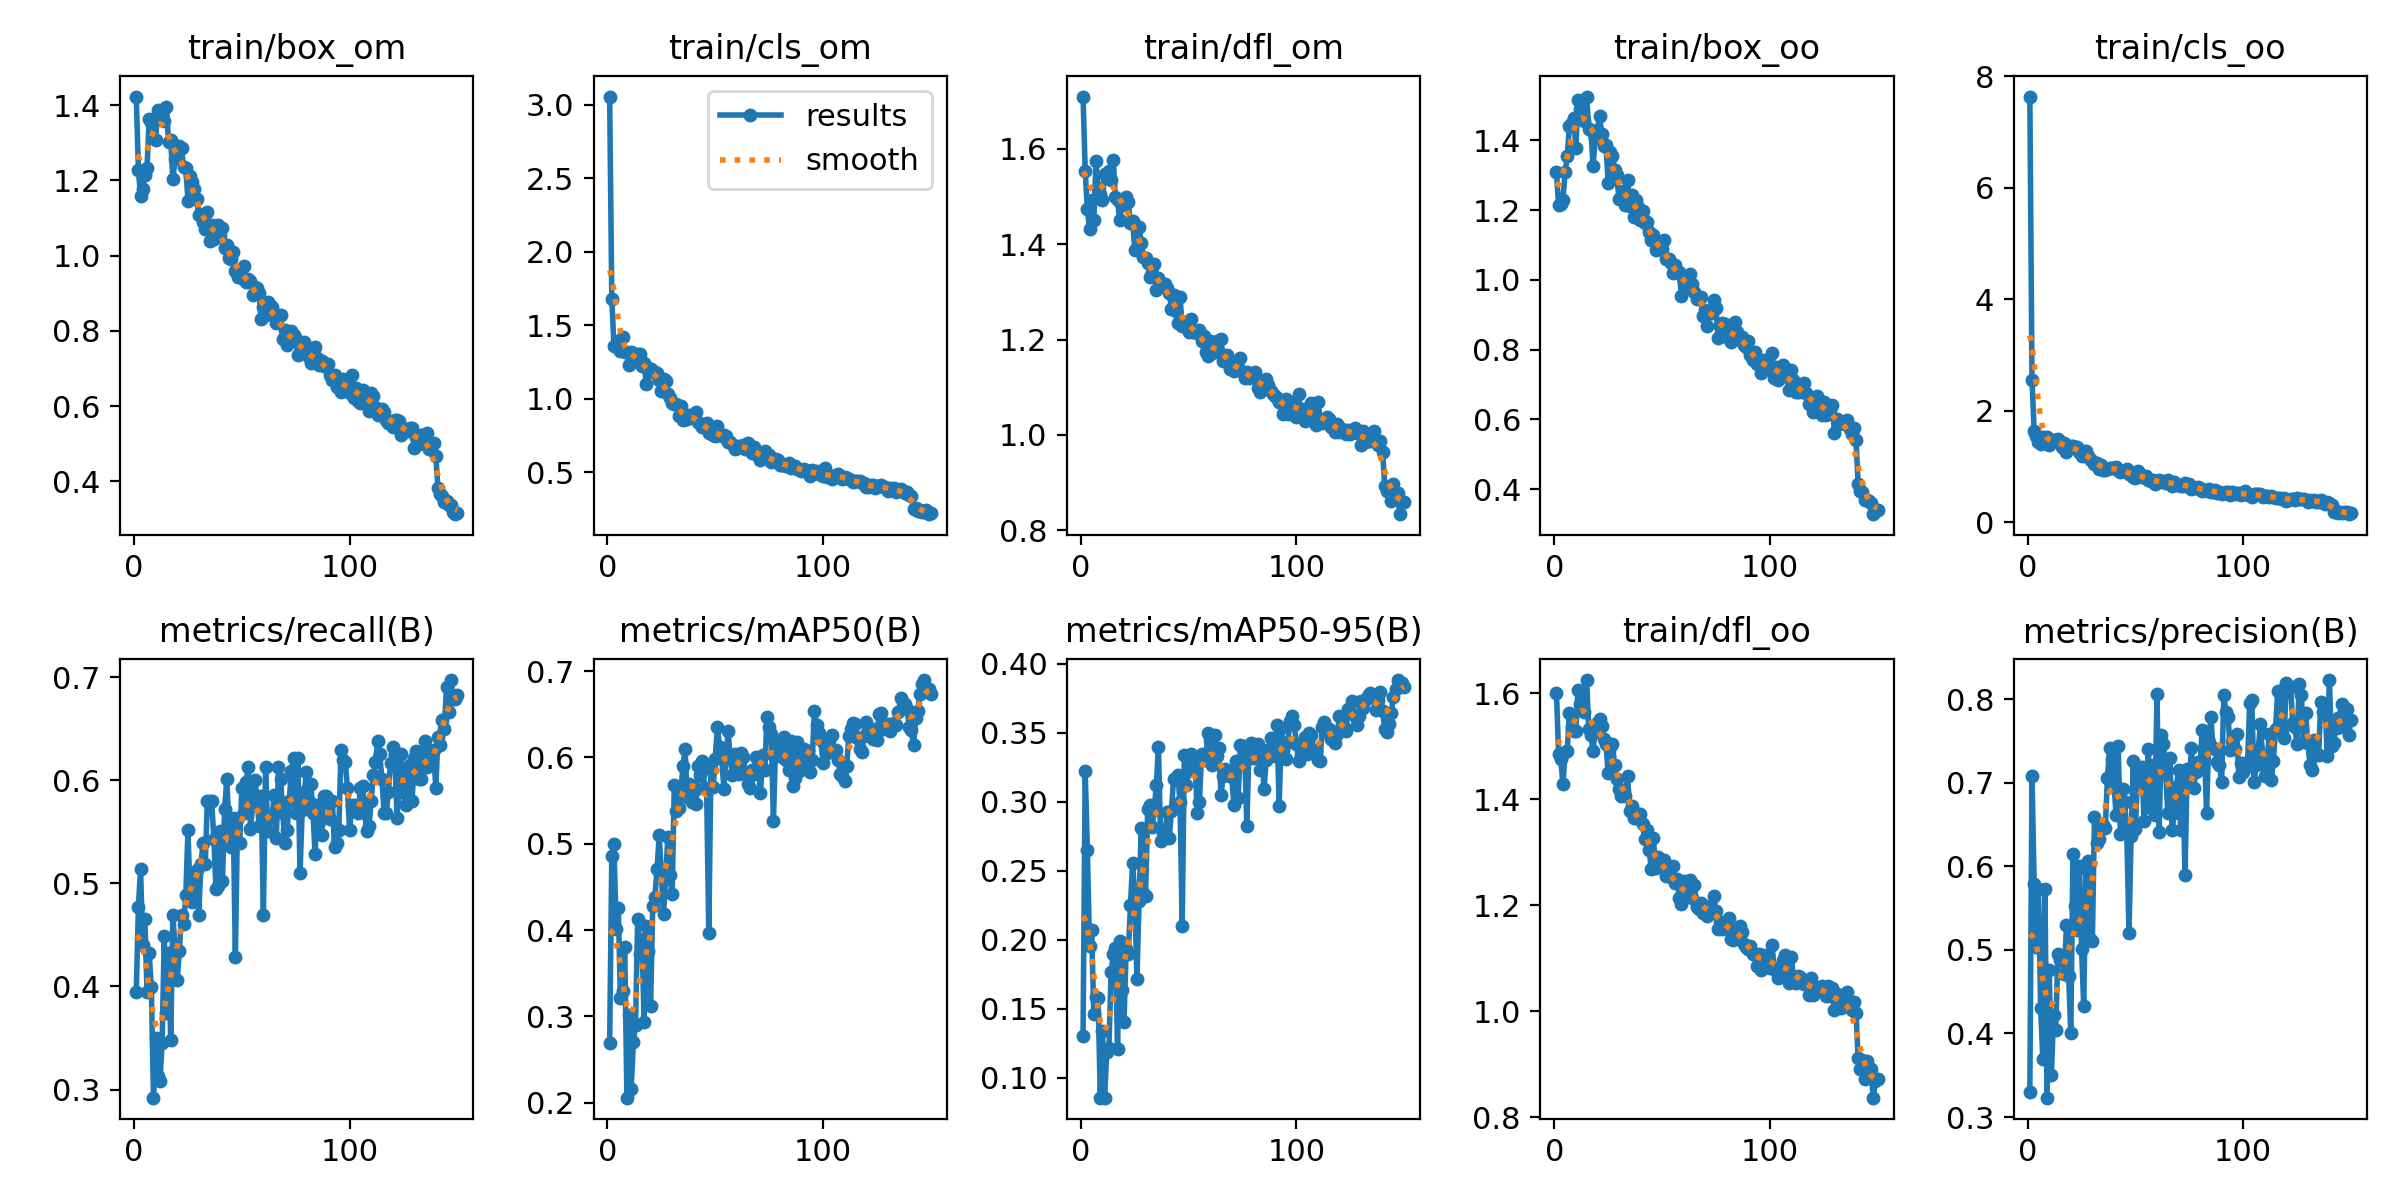

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

At this point in time, we have tried yolov10n, yolov10s and yolov10m. There is a bit of improvement but not much, which suggests that the quality of the data is not enough. We should scrape more images and of higher quality, but it is a first good exercise.

### *2.2.4 Evaluating on validation set with random images*


In [14]:
model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt') #train3

metrics = model.val(
    plots=True,
    save_json=True,
    conf=0.1,
    iou=0.6
    ) #try a few different values of conf and iou

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv10s summary (fused): 293 layers, 8035734 parameters, 0 gradients, 24.4 GFLOPs


val: Scanning /content/datasets/Rat-Detector-3/valid/labels.cache... 132 images, 11 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:01<00:08,  1.03s/it]Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.08it/s]


                   all        132        243      0.763      0.704      0.678      0.379
Speed: 1.0ms preprocess, 18.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val


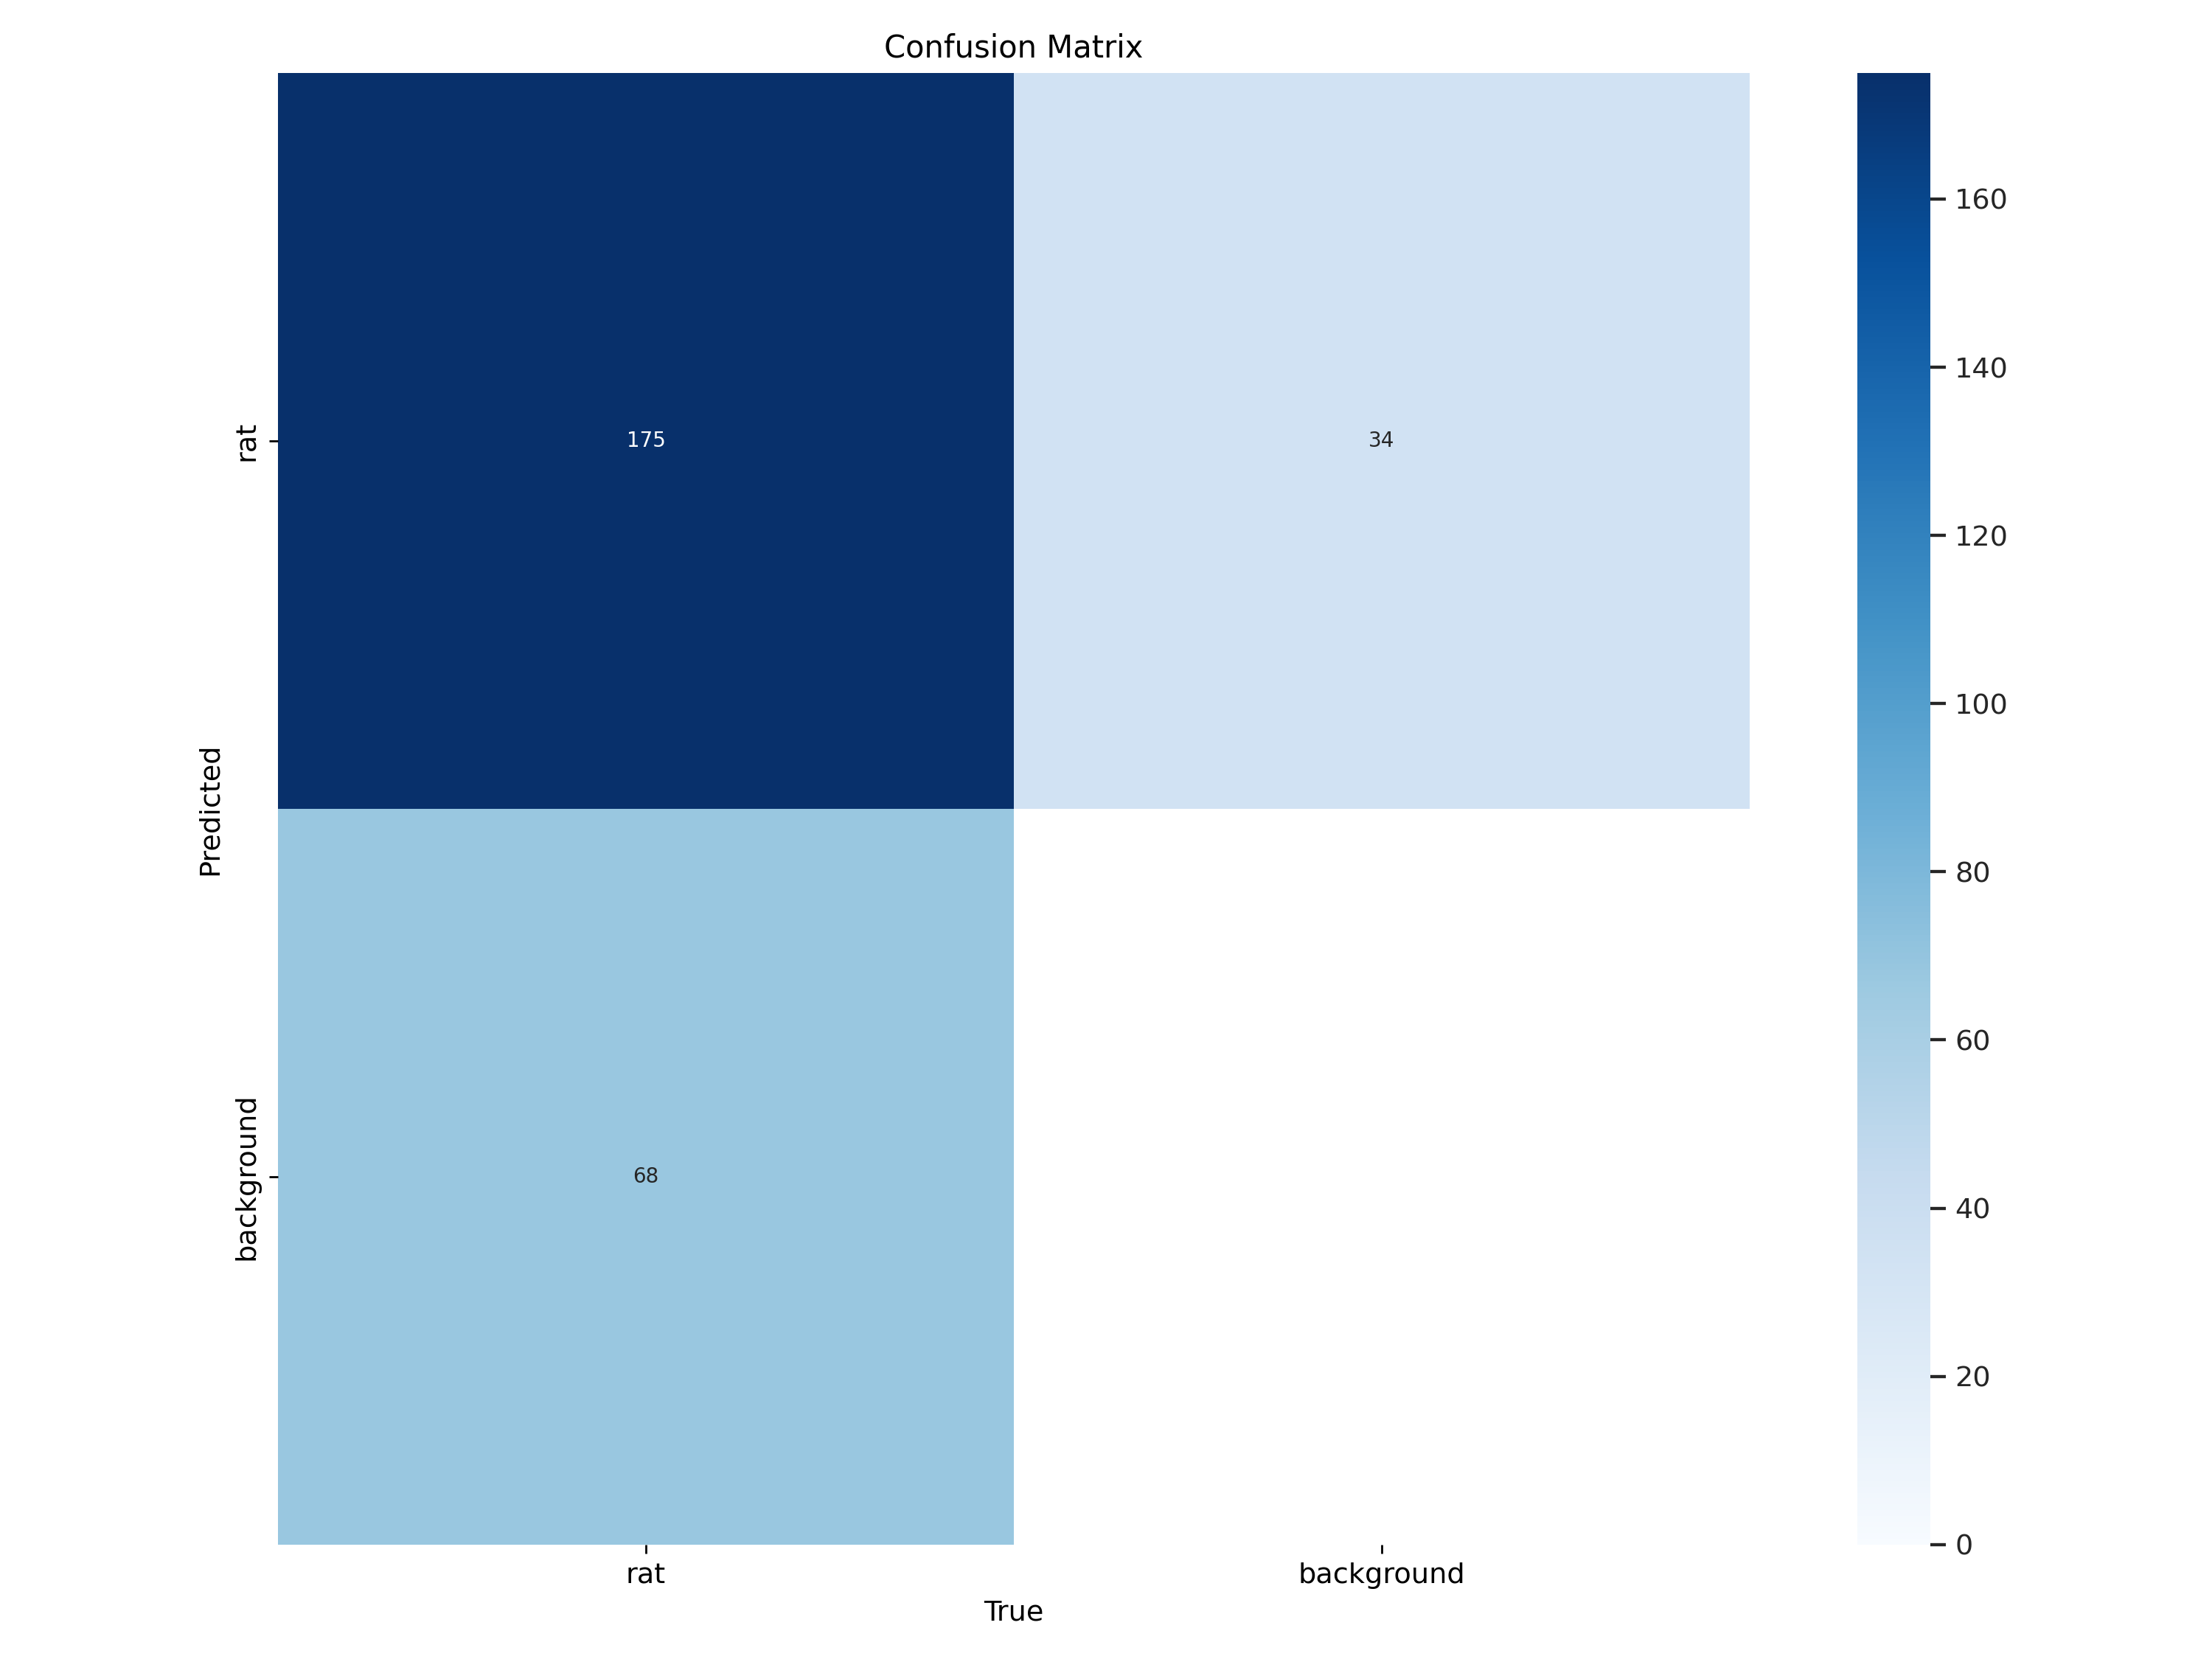

In [15]:
Image(filename=f'{HOME}/runs/detect/val/confusion_matrix.png', width=600)

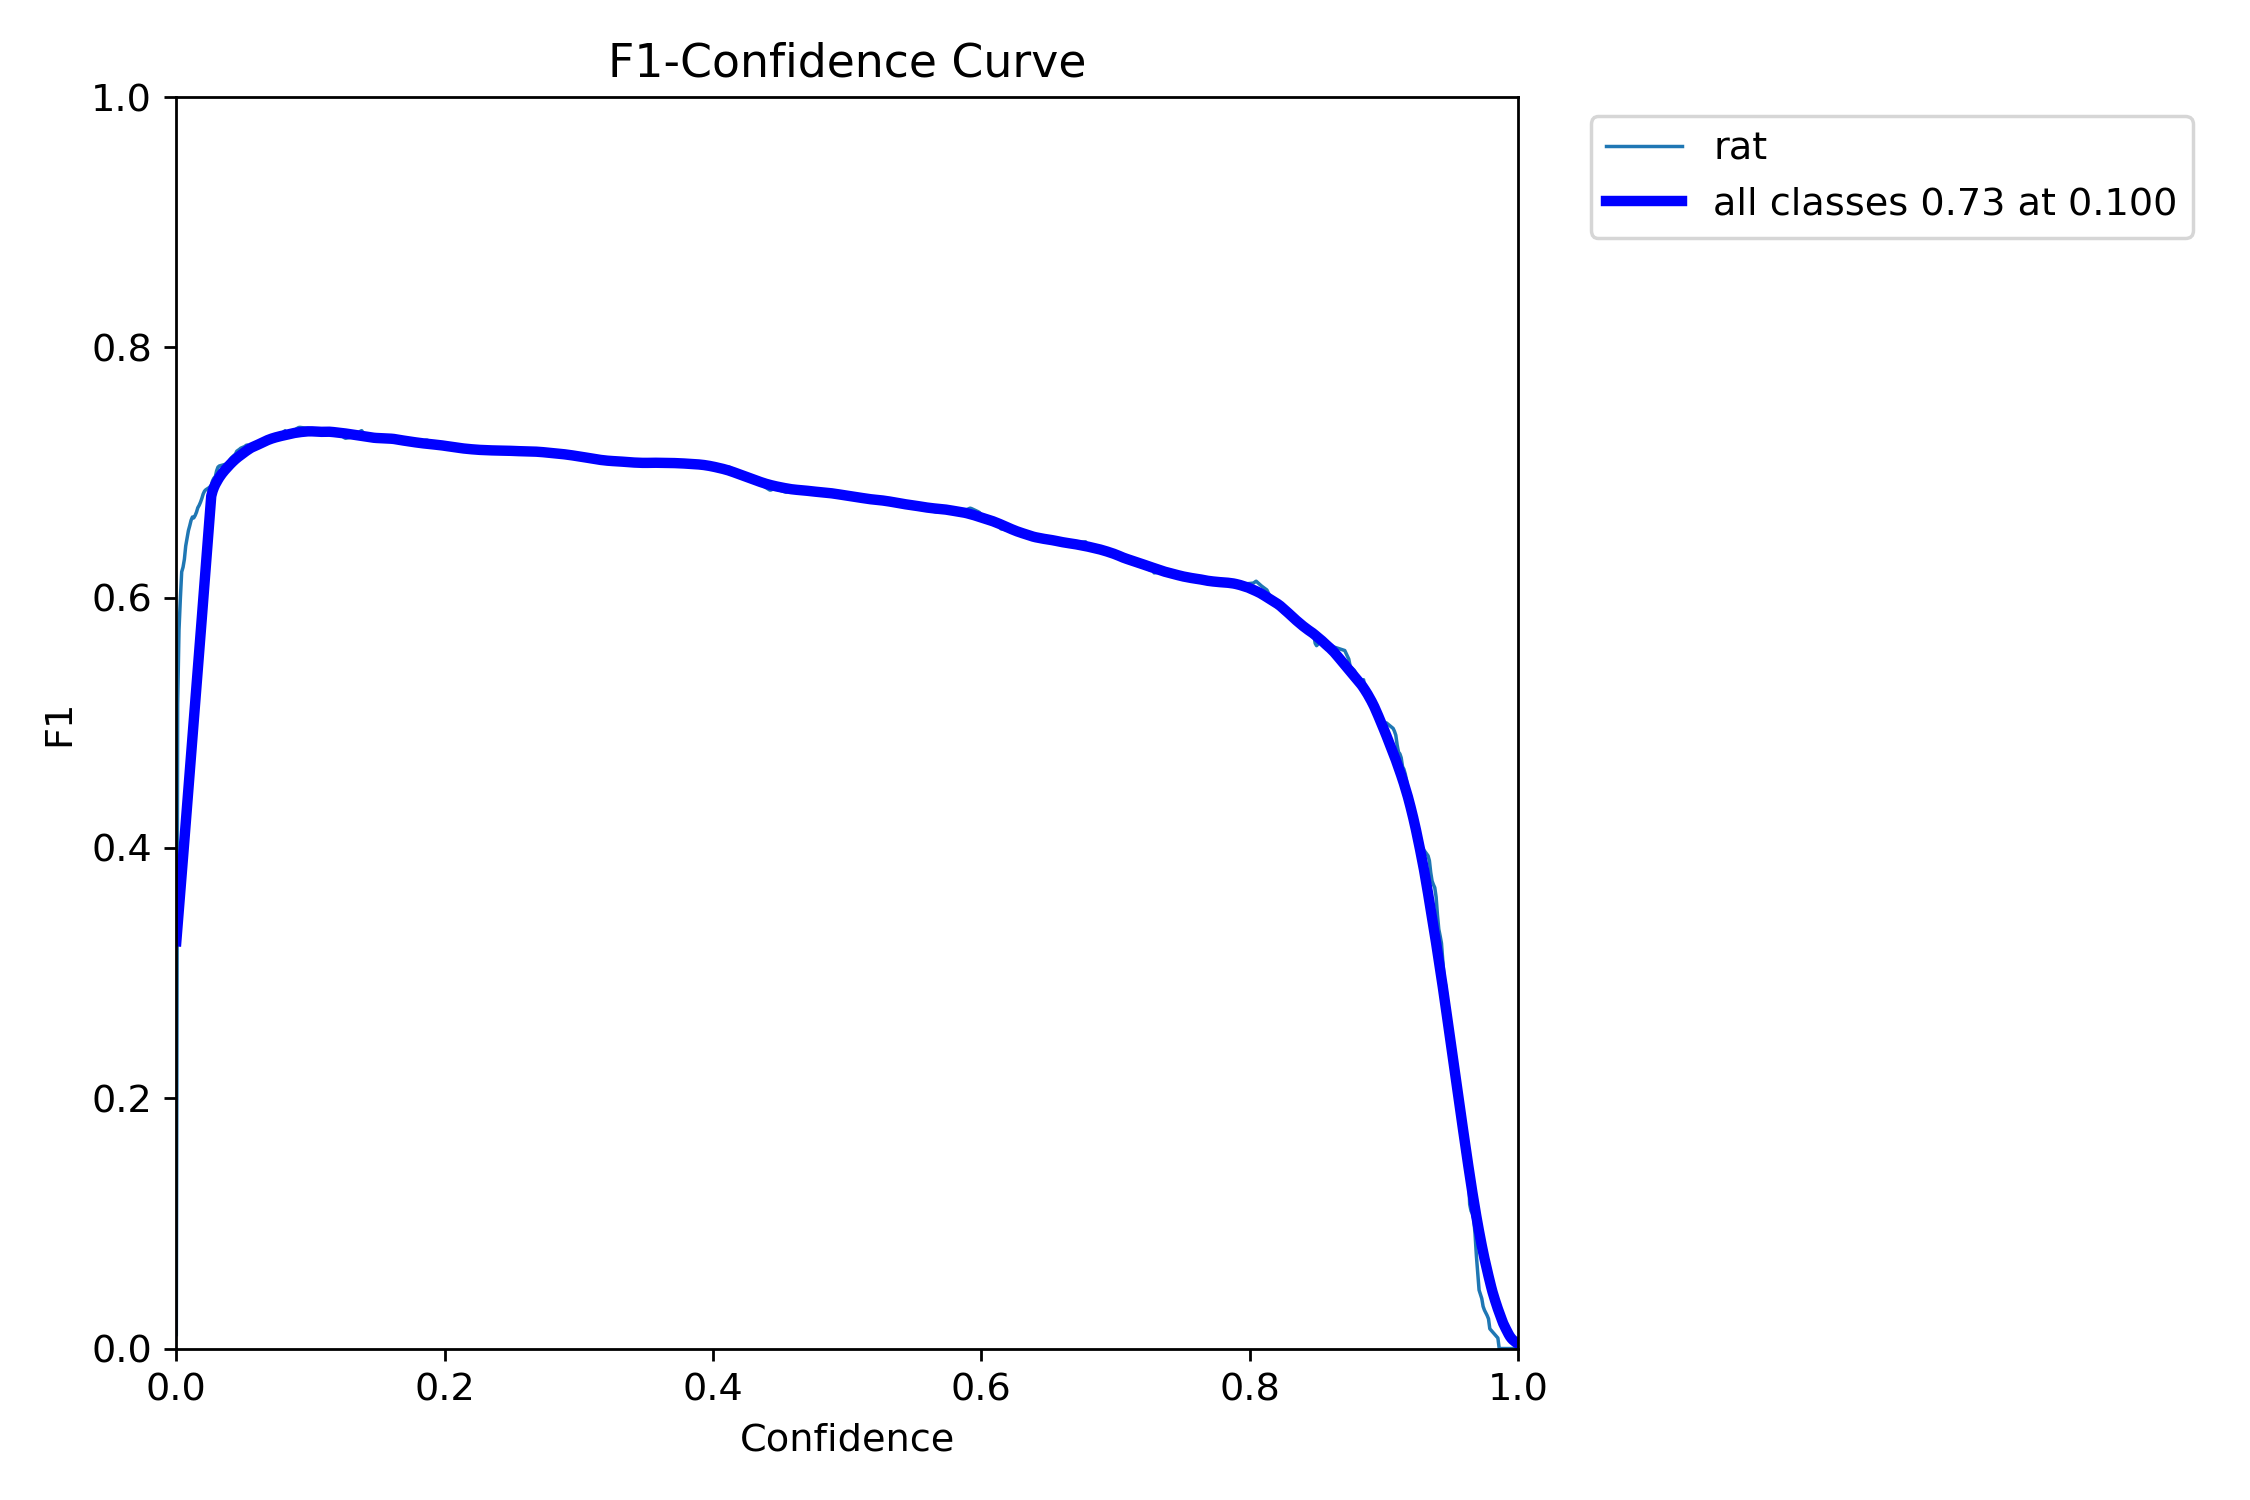

In [16]:
Image(filename=f'{HOME}/runs/detect/val/F1_curve.png', width=600)

So we are detecting 63% of the rats correctly by adjusting the F1/confidence to 0.1, but we are still having lots of issues with the background.

## 2.3. Evaluation and test on random scraped images.

### *2.3.1 Building the image scraper*

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!pip install -q selenium
!apt-get update
!apt install -y -q chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,556 kB]
Hit:10 https://ppa.launchpadcont

In [19]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import requests
import os

# Set up the Chrome options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--remote-debugging-port=9222')
options.add_argument('--disable-gpu')
# Ensure the correct path to the ChromeDriver
options.binary_location = '/usr/bin/google-chrome-stable'

# Set up the WebDriver
driver = webdriver.Chrome(options=options)

# Define the directory to save images
save_dir = '/content/drive/MyDrive/IE/IndividualAssignmentMBD/RatImages'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

try:
    # Open Google Images
    driver.get('https://images.google.com/')

    # Find the search box
    search_box = driver.find_element(By.NAME, 'q')

    # Search for images of "rats"
    search_box.send_keys('rats in nature')
    search_box.send_keys(Keys.RETURN)

    # Wait for the results to load
    time.sleep(3)  # Adjust the sleep time based on your internet speed

    # Scroll down to load more images (optional)
    scroll_pause_time = 2
    max_scrolls = 5
    last_height = driver.execute_script("return document.body.scrollHeight")

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    # Find image elements
    thumbnails = driver.find_elements(By.CSS_SELECTOR, 'img')

    # Click on each thumbnail to get the larger image
    image_urls = []
    for thumbnail in thumbnails:
        try:
            thumbnail.click()
            time.sleep(3)  # Adjust the sleep time based on your internet speed
            images = driver.find_elements(By.CSS_SELECTOR, 'img.n3VNCb')
            for image in images:
                url = image.get_attribute('src')
                if url and 'http' in url:
                    image_urls.append(url)
                    break
        except Exception as e:
            print(f"Could not retrieve image URL: {e}")

    # Download and save the images
    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(os.path.join(save_dir, f'rat_{i}.jpg'), 'wb') as file:
                    file.write(response.content)
        except Exception as e:
            print(f"Could not download {url}: {e}")

    print(f"Downloaded {len(image_urls)} images.")

finally:
    # Close the WebDriver
    driver.quit()


Se han truncado las últimas 5000 líneas del flujo de salida.
#8 0x5a1cd849d2aa <unknown>
#9 0x5a1cd8490001 <unknown>
#10 0x5a1cd84be5c2 <unknown>
#11 0x5a1cd848fad9 <unknown>
#12 0x5a1cd84be78e <unknown>
#13 0x5a1cd84dd303 <unknown>
#14 0x5a1cd84be363 <unknown>
#15 0x5a1cd848e247 <unknown>
#16 0x5a1cd848eb9e <unknown>
#17 0x5a1cd873224b <unknown>
#18 0x5a1cd87362f1 <unknown>
#19 0x5a1cd871dafe <unknown>
#20 0x5a1cd8736e52 <unknown>
#21 0x5a1cd870279f <unknown>
#22 0x5a1cd875b638 <unknown>
#23 0x5a1cd875b810 <unknown>
#24 0x5a1cd876adac <unknown>
#25 0x7d47c31c2ac3 <unknown>

Could not retrieve image URL: Message: stale element reference: stale element not found
  (Session info: chrome-headless-shell=126.0.6478.126); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
#0 0x5a1cd876bc7a <unknown>
#1 0x5a1cd844ee2c <unknown>
#2 0x5a1cd845f504 <unknown>
#3 0x5a1cd845fe6a <unknow

In [20]:
import requests
from bs4 import BeautifulSoup
import os

# Define the directory to save images
save_dir = '/content/drive/MyDrive/Computer_Vision/Individual_Assignment/ScrapedRatImages'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the search query
search_query = 'rats in nature and the street'

# Define the URL for Google Images search
search_url = f"https://www.google.com/search?tbm=isch&q={search_query.replace(' ', '+')}"

# Send a GET request to Google Images
response = requests.get(search_url)

# Parse the response content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find all image elements
image_elements = soup.find_all('img')

# Extract image URLs
image_urls = [img['src'] for img in image_elements if 'src' in img.attrs]

# Download and save the images
for i, url in enumerate(image_urls):
    try:
        if not url.startswith('http'):
            url = 'https:' + url
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(save_dir, f'rat_{i}.jpg'), 'wb') as file:
                file.write(response.content)
    except Exception as e:
        print(f"Could not download {url}: {e}")

print(f"Downloaded {len(image_urls)} images.")


Could not download https:/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif: Invalid URL 'https:/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No host supplied
Downloaded 21 images.


In [21]:
folder_path = '/content/drive/MyDrive/Computer_Vision/Individual_Assignment/ScrapedRatImages/'
file_list = os.listdir(folder_path)

image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
image_files = [folder_path+file for file in file_list if file.lower().endswith(image_extensions)]


first_ten_images = image_files[:10] #By changing the slicing different images will be shown.

### *2.3.2 Running the model and predicting on the downloaded images*

In [22]:
results = model(first_ten_images, conf=0.1, iou=0.8)  #Return a list of annotated images.

for i, result in enumerate(results):
    boxes = result.boxes #Boxes
    result.plot() #Plot detection results
    result.save(filename=f"result_{i}.jpg")  #Save to disk


0: 640x640 1 rat, 16.9ms
1: 640x640 2 rats, 16.9ms
2: 640x640 2 rats, 16.9ms
3: 640x640 1 rat, 16.9ms
4: 640x640 1 rat, 16.9ms
5: 640x640 1 rat, 16.9ms
6: 640x640 2 rats, 16.9ms
7: 640x640 1 rat, 16.9ms
8: 640x640 3 rats, 16.9ms
9: 640x640 1 rat, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


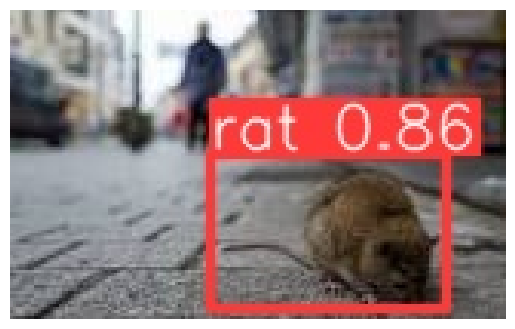

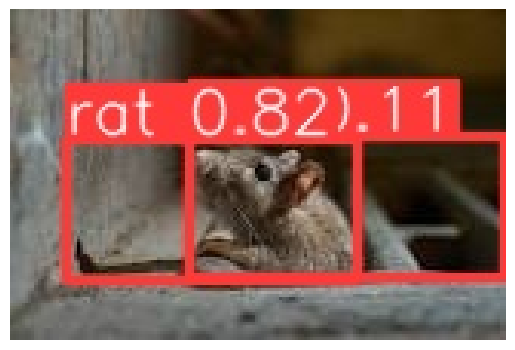

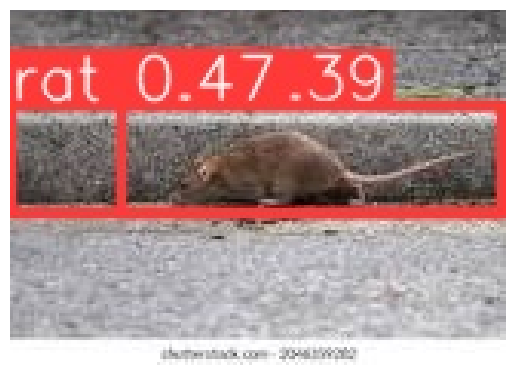

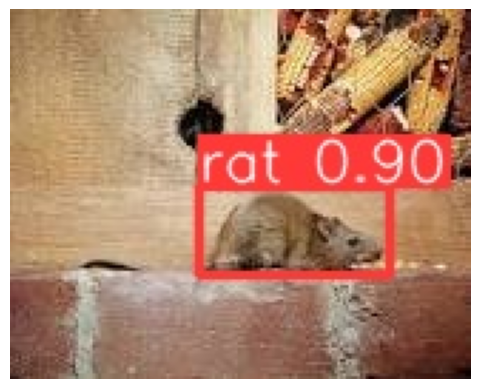

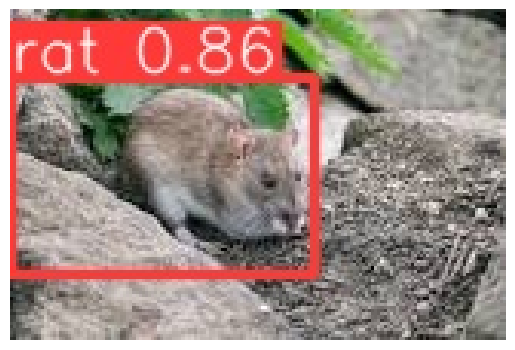

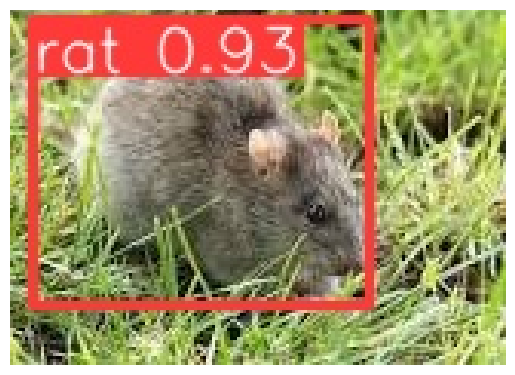

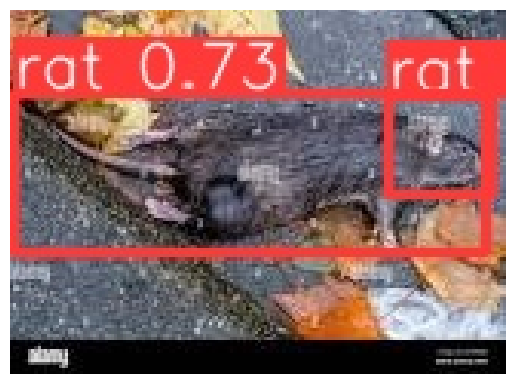

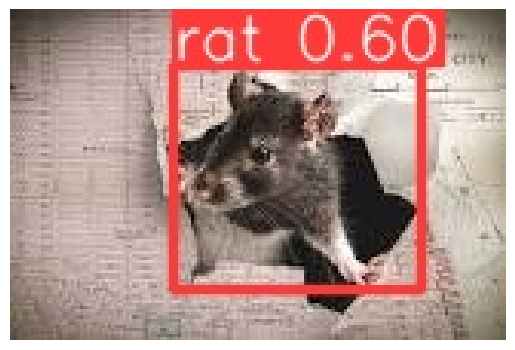

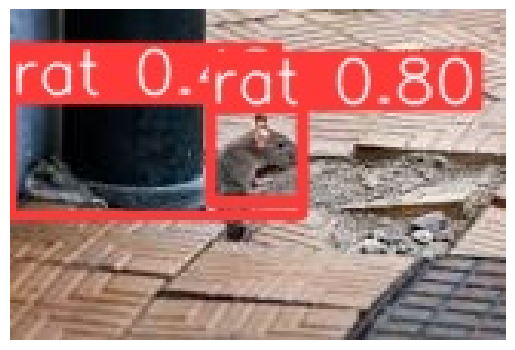

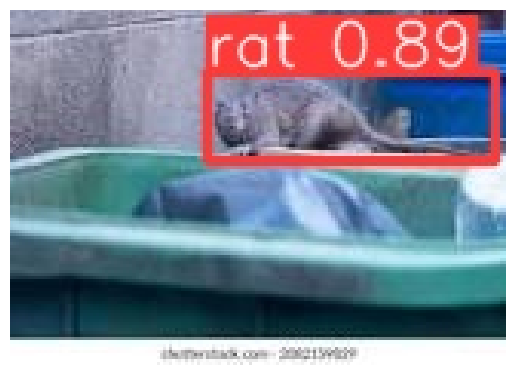

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Assume 'results' is a list of objects where each object has 'boxes' and 'plot()' method
for i, result in enumerate(results):
    img = Image.open(f"result_{i}.jpg")  # Load the image corresponding to the result
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()  # Display the plot

    # Save the figure
    fig.savefig(f"result_{i}.jpg", bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the plot figure to free up memory


Here we can see some mistakes we made when annotating the data! It recognises the nose as another rat, just because in the annotated dataset there were many rats on images where we anotated bodies (even if we did not see the face) and only faces.

# **Step 3. Downloading the created model and dataset in the Colab Environment**



In [24]:
import os
import shutil

# Source and target directories
source_folder = '/content/'  # Default directory for your Colab files
target_folder = '/content/drive/My Drive/Computer_Vision/Individual_Assignment/'  # Adjusted target path

# Ensure the target directory exists
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# List of specific folders to move
folders_to_move = ['datasets', 'runs']

# Loop through the specific folders and copy them
for folder in folders_to_move:
    src_folder_path = os.path.join(source_folder, folder)
    dst_folder_path = os.path.join(target_folder, folder)

    if os.path.exists(src_folder_path):
        if os.path.isdir(src_folder_path):
            # Use shutil.copytree to copy the directory
            shutil.copytree(src_folder_path, dst_folder_path, dirs_exist_ok = True)  # dirs_exist_ok parameter used here
        else:
            print(f"Expected {src_folder_path} to be a directory.")
    else:
        print(f"Directory {src_folder_path} does not exist.")
